In [1]:
import numpy as np

from GmGM import GmGM
from GmGM.synthetic import PrecMatGenerator, DatasetGenerator
from GmGM.synthetic import measure_prec_recall, plot_prec_recall

In [2]:
generator = DatasetGenerator(
    structure={
        "rna": ("cell", "gene"),
        "atac": ("cell", "peak"),
    },
    generator={
        "cell": PrecMatGenerator(),
        "gene": PrecMatGenerator(),
        "peak": PrecMatGenerator(),
    },
    size={
        "cell": 51,
        "gene": 52,
        "peak": 53
    },
)
generator

In [3]:
generator.generate()

Dataset(
	rna: ('', 'cell', 'gene')
	atac: ('', 'cell', 'peak')
)
Axes(
	cell: 51
		Prior: None
		Gram: Not calculated
		Eig: Not calculated
	peak: 53
		Prior: None
		Gram: Not calculated
		Eig: Not calculated
	gene: 52
		Prior: None
		Gram: Not calculated
		Eig: Not calculated
)

Attempt 1/5
Lambda #0
Algorithm: GmGM
Attempt 2/5
Lambda #0
Algorithm: GmGM
Attempt 3/5
Lambda #0
Algorithm: GmGM
Attempt 4/5
Lambda #0
Algorithm: GmGM
Attempt 5/5
Lambda #0
Algorithm: GmGM


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Recall', ylabel='Precision'>)

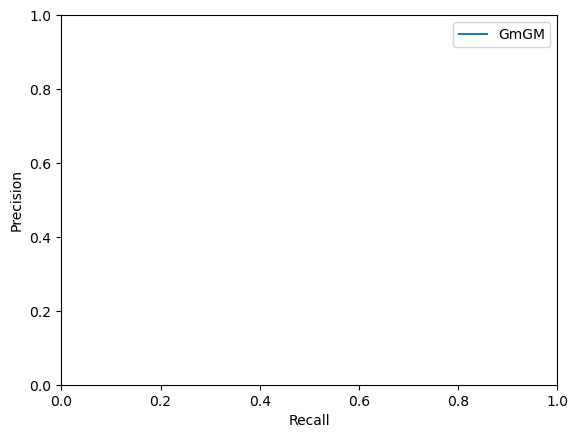

In [4]:
# TODO: find out why this is getting slower over time - memory leak?
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
    },
    Lambdas={
        "GmGM": np.linspace(0.01, 1, 1)
    },
    num_attempts=5,
    num_samples=10,
    verbose=3,
)
plot_prec_recall(
    results,
    axis = "cell",
    generator=generator,
)

In [5]:
def test():
    results = measure_prec_recall(
        generator,
        algorithms={
            "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        },
        Lambdas={
            "GmGM": np.linspace(0.01, 1, 20)
        },
        num_attempts=5,
        num_samples=10,
        verbose=0,
    )
from GmGM import calculate_eigenvalues
#print(_project_inv_kron_sum.two_axis.inspect_types())
%load_ext line_profiler
%lprun -f measure_prec_recall -f GmGM -f calculate_eigenvalues test()

Timer unit: 1e-09 s

Total time: 2.374 s
File: /Users/baileyandrew/mambaforge/envs/GmGM-python-demo/lib/python3.9/site-packages/GmGM/GmGM.py
Function: GmGM at line 29

Line #      Hits         Time  Per Hit   % Time  Line Contents
    29                                           def GmGM(
    30                                               dataset: Dataset | AnnData,
    31                                               to_keep: float | int | dict[Axis, float | int],
    32                                               random_state: Optional[int] = None,
    33                                               batch_size: Optional[int] = None,
    34                                               verbose: bool = False,
    35                                               # `center` parameters
    36                                               centering_method: Optional[Literal["avg-overall", "clr-prost"]] = None,
    37                                               # `create_gram_matrices

In [6]:
results

[{'GmGM': {'peak': {'precision': 0.0,
    'recall': 0.0,
    'precision_std': 0.0,
    'recall_std': 0.0},
   'gene': {'precision': 0.0,
    'recall': 0.0,
    'precision_std': 0.0,
    'recall_std': 0.0},
   'cell': {'precision': 0.0,
    'recall': 0.0,
    'precision_std': 0.0,
    'recall_std': 0.0}}}]

In [7]:
import numba as nb
def two_axis(
    x: np.ndarray,
    y: np.ndarray
) -> tuple[np.ndarray]:
    k_ratio: float = 1./2.
    x_out: np.ndarray = np.zeros(x.shape[0])
    y_out: np.ndarray = np.zeros(y.shape[0])

    for i in nb.prange(x.shape[0]):
        for j in nb.prange(y.shape[0]):
            cur_val: float = 1 / (x[i]+y[j])
            x_out[i] += cur_val
            y_out[j] += cur_val

    # Normalize
    x_out /= x.shape[0]
    y_out /= y.shape[0]

    # Offset diagonal
    x_out -= k_ratio * np.sum(x_out) / x.shape[0]
    y_out -= k_ratio * np.sum(y_out) / y.shape[0]

    return x_out, y_out

two_axis_numba = nb.jit(
    nb.types.UniTuple(nb.float64[:],2)(nb.float64[:],nb.float64[:]),
    nopython=True,
    fastmath=True,
    parallel=False,
    cache=True
)(two_axis)

In [8]:
for _ in range(1_000):
    x = 1+np.random.rand(50)
    y = 1+np.random.rand(50)
    warmup = two_axis_numba(x,y)
print("warmup over")
%timeit two_axis(x,y)
%timeit two_axis_numba(x,y)

warmup over
920 µs ± 30.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
9.61 µs ± 55.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
